# Environement set up details

## Installing locally (rather than colab)

Using `uv` (from https://docs.astral.sh/uv/)

```
# install uv in its own global location (using pipx)
pipx install uv
# create a virtual environment
uv venv
# activate the environment
source .venv/bin/activate
# install the Jupyter notebook packages
uv pip install ipykernel jupyter notebook
# install required packages
uv pip install numpy pandas matplotlib


In [2]:
# imports for the project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

## Use the same iris data

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

df.tail()

# Extract the first hundred class labels (it is known that 50 are Iris-setosa and 50 are Iris-virginica)
y = df.iloc[0:100, 4].values
# update the class labels to -1 or 1
y = np.where(y == 'Iris-setosa', -1, 1)
# Extract the first hundred features in columns 0 and 1, representively representing sepal length and petal length
X = df.iloc[0:100, [0, 2]].values


## The code for the Adaline class

In [4]:
class AdalineGD(object):
    """ADAptive LINEar neuron classifier.

    Adaline implements a continuous linear activation function (identity)
    and uses gradient descent to minimize the cost function, making it
    different from the Perceptron which uses a unit step function.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data using gradient decent

        Unlike the Perceptron, Adaline updates weights based on a continuous
        linear activation function rather than a threshold function, which
        allows for gradient-based optimization.

        Implementation steps:
        1. Initialize weights with small random values
        2. For each epoch:
           a. Calculate the net input (weighted sum via the aggregation function)
           b. Apply activation function (in this case it is the identity function)
           c. Calculate errors (difference between actual and predicted)
           d. Calculate the derivative (gradient) of the cost function wrt the weights and bias
           e. Update all weights and biases based on the derivatives multipled by the learning rate
           f. Calculate and store cost for this epoch

        Note: the deriveative of the cost function wrt the weights is calculated using the chain rule:
          ∂E/∂w_j = ∂E/∂φ * ∂φ/∂z * ∂z/∂w_j

        where:
          ∂E/∂φ = -(y - φ) = (φ - y)  [The actual output (aggregation_function) minus the desired output (y)]
          ∂φ/∂z = 1                   [The derivative of the activation (activation_function) wrt the net input (aggregation_function)]
          ∂z/∂w_j = x_j               [The derivative of the net input (aggregation_function) wrt the jth input (X_j)]

        Here we jump to using numpy in the code.

        The important thing to remember is... the Jacobian matrix is the first order derivative of the cost function.

        Rather than looping though each input (also called a feature) and updating the weights, we can use matrix multiplication to update all weights at once.

        The matrix multiplication is done by taking the dot product of the transpose of the input matrix (X.T) and the error vector (y - self.activation_function(self.aggregation_function(X))).

        This reduces to this code:
          X.T.dot(X.dot(w) - y) = X.T.dot(y - self.activation_function(self.aggregation_function(X)))

        In the for loop below this code is broken out to mirror the steps in the algorithm.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        # Step 1: Initialize weights with small random values
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            # Step 2a: Calculate net input (weighted sum via aggregation_function)
            net_input = self.aggregation_function(X)

            # Step 2b: Apply activation function (in this case it is the identity function)
            output = self.activation_function(net_input)

            # Step 2c: Calculate prediction error
            error_vector = output - y

            # Step 2d: Calculate the derivative (gradient) of the cost function wrt the weights and bias
            # using the chain rule: ∂E/∂w = X.T.dot(output - y)
            derivative_cost_wrt_weights = X.T.dot(error_vector)
            derivative_cost_wrt_bias = error_vector.sum()

            # Step 2e: Apply standard gradient descent update: w = w - eta * gradient
            self.w_[1:] -= self.eta * derivative_cost_wrt_weights
            self.w_[0] -= self.eta * derivative_cost_wrt_bias

            # Step 2f: Calculate and store cost
            cost = (error_vector**2).sum() / 2.0  # Sum of squared errors / 2
            self.cost_.append(cost)
        return self

    def aggregation_function(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation_function(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation_function(self.aggregation_function(X)) >= 0.0, 1, -1)

## Viewing the decision boundaries

### The clean version - conclusion

In [5]:
def run_adaline_analysis(X, y, custom_config=None):
    """
    Run Adaline analysis with a specified configuration

    Parameters:
    X : array-like, default feature matrix (used only if no input_data in config)
    y : array-like, target vector
    custom_config : dict, custom configuration (optional)

    Returns:
    list of trained models
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap
    import inspect
    import re
    
    # Function to find variable name from calling frame
    def get_variable_name(var):
        callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
        return [var_name for var_name, var_val in callers_local_vars if var_val is var]
    
    # Default configuration
    default_config = {
        "input_data": [X, X, X],  # Default to using the input X
        "learning_rates": [0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005],
        "n_iters": [10, 15, 20, 25, 30, 35],
        "markers": ['o', 'x', 'x', 'o', '+', '+']
    }

    # Use custom config if provided, otherwise use default
    config = custom_config if custom_config is not None else default_config

    # Extract configuration values
    input_data_list = config["input_data"]
    learning_rates = config["learning_rates"]
    n_iters = config["n_iters"]
    markers = config.get("markers", ['o'] * len(learning_rates))

    # Get the number of data sets and experiments per dataset
    n_data_sets = len(input_data_list)
    n_experiments = len(learning_rates)  # All learning rates used for each dataset
    
    # Create a figure with n_data_sets*2 rows, n_experiments columns
    fig, axes = plt.subplots(
        nrows=2*n_data_sets, 
        ncols=n_experiments, 
        figsize=(3*n_experiments, 4*n_data_sets)
    )
    
    # Handle the case when there's only one row or column
    if n_data_sets == 1 and n_experiments == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    elif n_data_sets == 1:
        axes = axes.reshape(2, n_experiments)
    elif n_experiments == 1:
        axes = axes.reshape(2*n_data_sets, 1)
    
    # Train models and plot results
    models = []
    
    for data_idx, X_data in enumerate(input_data_list):
        # Calculate row indices for this data set
        row_learning = data_idx * 2
        row_decision = data_idx * 2 + 1
        
        # Handle different input formats
        if isinstance(X_data, tuple) and len(X_data) == 2:
            X, data_label = X_data
        else:
            X = X_data
            # Try to get the variable name
            var_names = get_variable_name(X_data)
            if var_names:
                data_label = f"Dataset {var_names[0]}"
            else:
                data_label = f"Dataset {data_idx+1}"
            
        # Add a title for this data set
        if axes.ndim == 2 and axes.shape[1] > 0:
            axes[row_learning, 0].text(-0.3, 0.5, data_label, 
                                      rotation=90, 
                                      transform=axes[row_learning, 0].transAxes,
                                      ha='center', va='center',
                                      fontsize=12, fontweight='bold')
        
        # Train and plot for each parameter setting
        for i in range(n_experiments):
            # Get parameters for this experiment - same learning rates for each dataset
            eta = learning_rates[i]
            n_iter = n_iters[i] if i < len(n_iters) else n_iters[-1]  # Use last n_iter if not enough provided
            marker = markers[i] if i < len(markers) else 'o'  # Use 'o' as default if not enough markers
            
            # Train model
            model = AdalineGD(n_iter=n_iter, eta=eta).fit(X, y)
            models.append(model)
            
            # Row 1: Learning curves
            ax_learning = axes[row_learning, i]
            
            if i < 2:
                ax_learning.plot(range(1, len(model.cost_) + 1), np.log10(model.cost_), marker=marker)
                ax_learning.set_ylabel('log(SSE)')
            else:
                ax_learning.plot(range(1, len(model.cost_) + 1), model.cost_, marker=marker)
                ax_learning.set_ylabel('SSE')

            ax_learning.set_xlabel('Epochs')
            ax_learning.set_title(f'eta {eta}')

            # Row 2: Decision boundaries
            ax_decision = axes[row_decision, i]
            plot_decision_regions(X, y, classifier=model, resolution=0.02, ax=ax_decision)
            
            # Add legend to last plot in each row
            if i == n_experiments - 1:
                ax_decision.legend()

            ax_decision.set_xlabel('sepal length')
            ax_decision.set_ylabel('petal length')
            ax_decision.set_title(f'Decision Boundary (eta={eta})')

    plt.tight_layout()
    plt.show()

    return models

# Modify plot_decision_regions to accept an axis parameter
def plot_decision_regions(X, y, classifier, resolution=0.02, ax=None):
    """
    Plot decision regions for a classifier in a 2D feature space.

    Parameters:
    X : array-like, shape = [n_samples, n_features]
        Feature matrix.
    y : array-like, shape = [n_samples]
        Target vector.
    classifier : object
        Trained classifier with a predict method.
    resolution : float, optional (default=0.02)
        Resolution of the mesh grid used to plot the decision surface.
    ax : matplotlib axis, optional
        Axis to plot on. If None, uses current axis.

    This function visualizes the decision boundaries of a classifier by plotting
    the decision surface in a 2D feature space.
    """
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # If ax is None, get current axis
    if ax is None:
        ax = plt.gca()

    # Calculate grid of the features
    feature_1_min, feature_1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    feature_2_min, feature_2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a fine grid of points
    feature_1_values, feature_2_values = np.meshgrid(
        np.arange(feature_1_min, feature_1_max, resolution),
        np.arange(feature_2_min, feature_2_max, resolution)
    )

    # Flatten and transpose the grid for prediction
    feature_grid = np.array([feature_1_values.ravel(), feature_2_values.ravel()]).T

    # Use the classifier to predict labels for the grid
    label_per_point = classifier.predict(feature_grid)
    label_per_point = label_per_point.reshape(feature_1_values.shape)

    # Plot the decision surface
    ax.contourf(feature_1_values, feature_2_values, label_per_point,
               alpha=0.4, cmap=cmap)

    # Set plot limits
    ax.set_xlim(feature_1_values.min(), feature_1_values.max())
    ax.set_ylim(feature_2_values.min(), feature_2_values.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=[cmap(idx)],
            marker=markers[idx],
            label=cl,
            edgecolors='black'
        )

### Basline the training of data as-is

/tmp/ipykernel_584368/1097592709.py:185: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


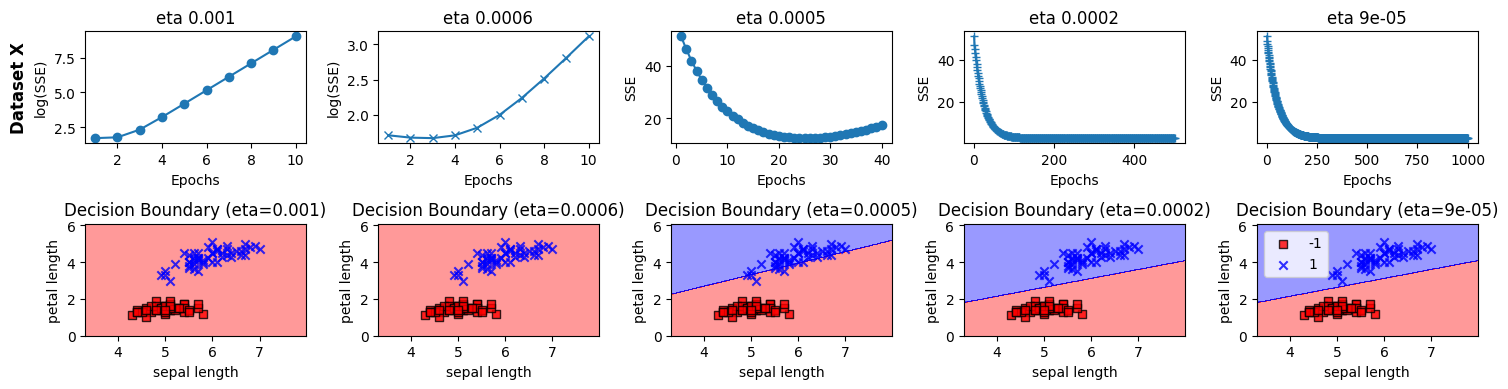

In [6]:
baseline_config = {
    "input_data": [X],  # Array of different datasets to try
    "learning_rates": [0.001, 0.0006, 0.0005, 0.0002, 0.00009],
    "n_iters": [10, 10, 40, 500, 1000],
    "markers": ['o', 'x', 'o', '+', '+']
}


# Run the analysis
models = run_adaline_analysis(X, y, custom_config=baseline_config)


### Normalising the data


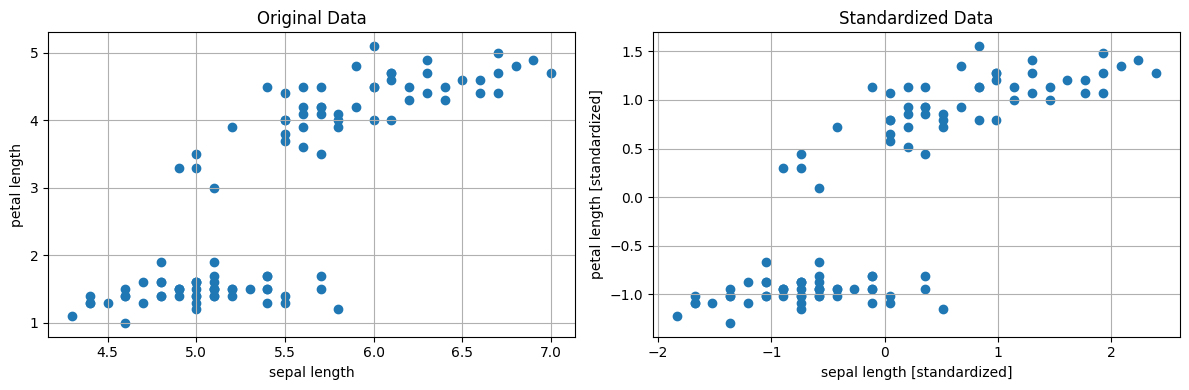


Original Data Statistics:
Feature 1 - Mean: 5.47, Std: 0.64
Feature 2 - Mean: 2.86, Std: 1.44

Standardized Data Statistics:
Feature 1 - Mean: -0.00, Std: 1.00
Feature 2 - Mean: -0.00, Std: 1.00


In [7]:
# standardize features

X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot original data
ax1.scatter(X[:, 0], X[:, 1])
ax1.set_title('Original Data')
ax1.set_xlabel('sepal length')
ax1.set_ylabel('petal length')

# Plot standardized data
ax2.scatter(X_std[:, 0], X_std[:, 1])
ax2.set_title('Standardized Data')
ax2.set_xlabel('sepal length [standardized]')
ax2.set_ylabel('petal length [standardized]')

# Add a grid for better visualization
ax1.grid(True)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Print some statistics to understand the transformation
print("\nOriginal Data Statistics:")
print(f"Feature 1 - Mean: {X[:, 0].mean():.2f}, Std: {X[:, 0].std():.2f}")
print(f"Feature 2 - Mean: {X[:, 1].mean():.2f}, Std: {X[:, 1].std():.2f}")

print("\nStandardized Data Statistics:")
print(f"Feature 1 - Mean: {X_std[:, 0].mean():.2f}, Std: {X_std[:, 0].std():.2f}")
print(f"Feature 2 - Mean: {X_std[:, 1].mean():.2f}, Std: {X_std[:, 1].std():.2f}")

/tmp/ipykernel_584368/1361600641.py:108: RuntimeWarning: overflow encountered in square
  cost = (error_vector**2).sum() / 2.0  # Sum of squared errors / 2
/tmp/ipykernel_584368/1097592709.py:185: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/mt/MSc/NeuralNetworks/background/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


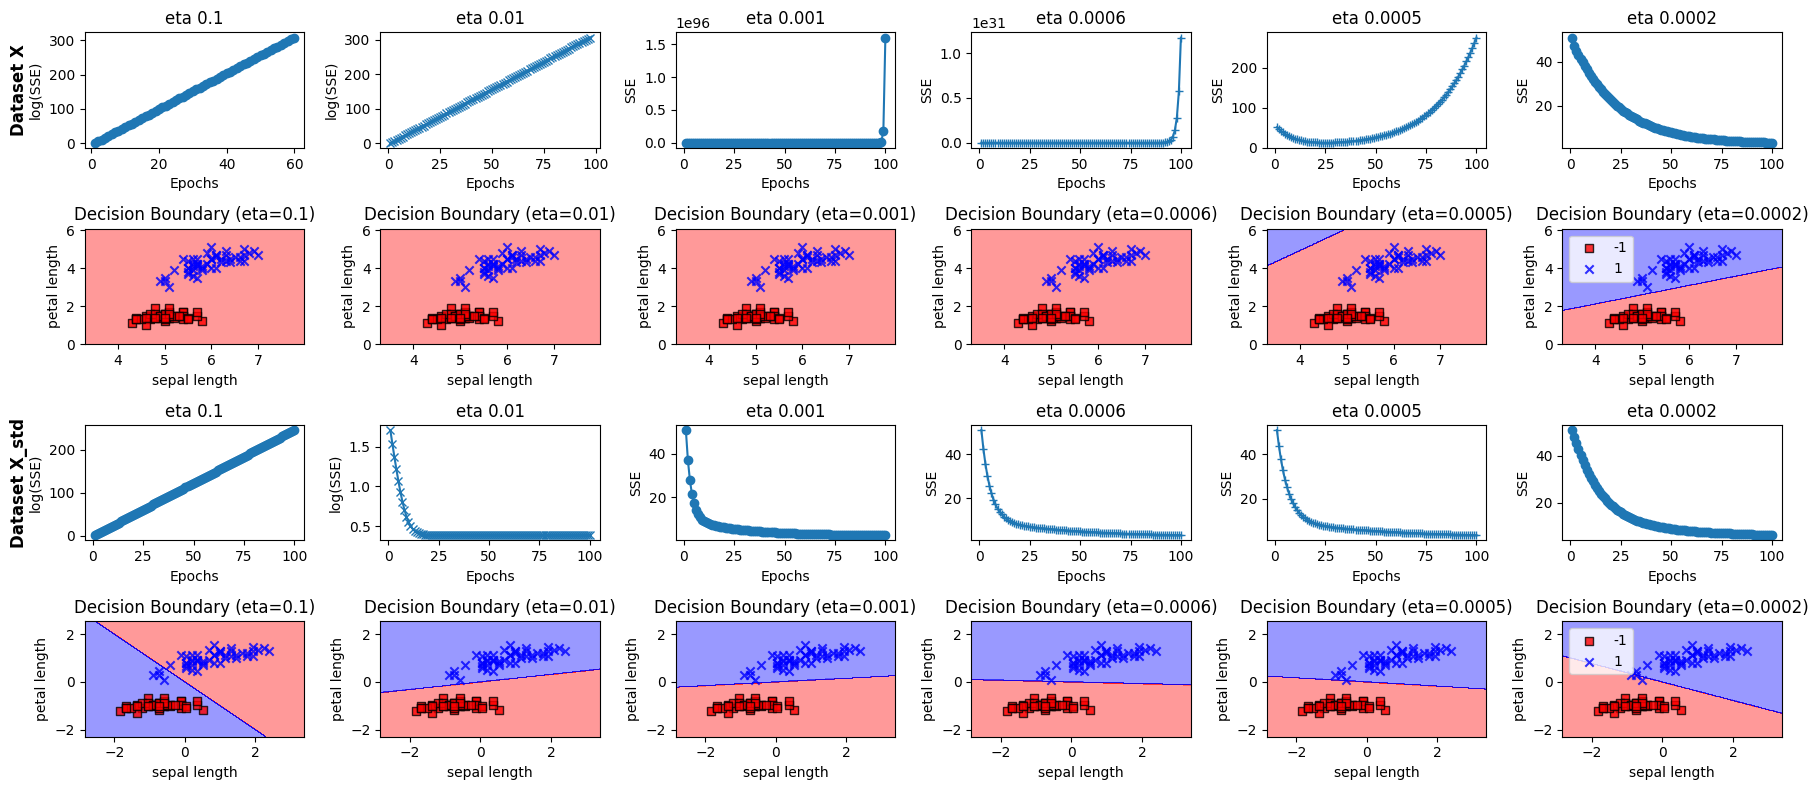

In [8]:
# Run the analysis
normalised_config = {
    "input_data": [X, X_std],  # Array of different datasets to try
    "learning_rates": [0.1, 0.01, 0.001, 0.0006, 0.0005, 0.0002],
    "n_iters": [100, 100, 100, 100, 100],
    "markers": ['o', 'x', 'o', '+', '+']
}


models = run_adaline_analysis(X_std, y, custom_config=normalised_config)